In [1]:
import os
import numpy as np
import pandas as pd

import trompy as tp

# the next two lines will expand the printed tables
# pd.options.display.max_rows= 40000
# pd.options.display.max_columns= 40000

In [2]:
DATA_FOLDER = "..\\data"

def tweak_fed(df):
    return (df
             .rename(columns={"MM:DD:YYYY hh:mm:ss": "t",
                             "InterPelletInterval": "ipi",
                             "Event": "event",
                             "FR": "fr",
                             "Device_Number": "device_number",
                             "Poke_Time": "poke_time"})
             .assign(t=lambda df_: pd.to_datetime(df_.t))
             .loc[:, ["t", "event", "fr", "device_number", "ipi", "poke_time"]]
           )

df = pd.read_csv(os.path.join(DATA_FOLDER, "FED001_041723_00.CSV"))
df1 = tweak_fed(df)

df = pd.read_csv(os.path.join(DATA_FOLDER, "FED002_041723_00.CSV"))
df2 = tweak_fed(df)

In [3]:
print(df1.head(3))
print(df2.head(3))

                    t   event  fr  device_number  ipi  poke_time
0 2023-04-17 11:18:10   Right   1              1  NaN      12.78
1 2023-04-17 11:19:11    Left   1              1  NaN       0.25
2 2023-04-17 11:21:57  Pellet   1              1  NaN        NaN
                    t  event  fr  device_number  ipi  poke_time
0 2023-04-17 11:18:20  Right   1              2  NaN      12.59
1 2023-04-17 11:25:38  Right   1              2  NaN       0.00
2 2023-04-17 11:26:38   Left   1              2  NaN       0.25


In [4]:
def sync_feds(df1, df2):
    
    offset = df2.query("poke_time > 10").t - df1.query("poke_time > 10").t
    offset = pd.Timedelta(offset.iloc[0])
    
    
    df2 = df2.assign(t=df2.t.sub(offset))
    
    return df1, df2, offset

In [5]:
METAFILE = "..\\FEDXD_METAFILE.xls"
rows, header = tp.metafilereader(METAFILE, sheetname="METAFILE_SE")

def prep4tidy(row):
    mouseid, sex, batch, fedfile, choice_session, fed_pellet, mode, diet = row
    
    df = tweak_fed(pd.read_csv(os.path.join(DATA_FOLDER, fedfile)))
    
    return (df
            .assign(mouseid = mouseid,
                    diet = diet,
                    sex = sex,
                    mode = mode,
                    choice_session = choice_session,
                    batch = int(batch),
                    fed_pellet = fed_pellet
                    )
           )

list_of_dfs = []
for row in rows:
    list_of_dfs.append(prep4tidy(row))
    
feddata = pd.concat(list_of_dfs)

File is excel file. Making csv metafile first


In [6]:
mice = feddata.mouseid.unique()

offsets, failed_keys, synced_dfs = [], [], []

for mouse in mice:
    # first adds dfs from zero sessions when only one fed available so no syncing necessary
    zero_df = feddata.query("mouseid == @mouse & choice_session == 'ZERO'")
    synced_dfs.append(zero_df)
    
    # then loops through sessions with choice of feds and syncs based on a long 'nose' poke
    for session in ["ONE", "TWO", "THREE", "FOUR"]:
        temp_df = feddata.query("mouseid == @mouse & choice_session == @session")

        devices = temp_df.device_number.unique()

        try:
            fed1 = temp_df.query("device_number == @devices[0]")
            fed2 = temp_df.query("device_number == @devices[1]")

            df1, df2, offset = sync_feds(fed1, fed2)
            synced_dfs.append(df1)
            synced_dfs.append(df2)
            offsets.append(offset.total_seconds())
        except IndexError:
            print(f"Cannot sync for {mouse} in choice session {session}")
            failed_keys.append((mouse, session))

feddata_synced = pd.concat(synced_dfs)

offsets = [0 if np.isnan(i) else i for i in offsets]
print(failed_keys)
print(offsets)

Cannot sync for FEDXDF12 in choice session ONE
Cannot sync for FEDXDF20 in choice session TWO
Cannot sync for FEDXDM18 in choice session ONE
Cannot sync for FEDXDM18 in choice session TWO
[('FEDXDF12', 'ONE'), ('FEDXDF20', 'TWO'), ('FEDXDM18', 'ONE'), ('FEDXDM18', 'TWO')]
[10.0, 11.0, 10.0, 9.0, 4.0, 5.0, 5.0, 7.0, 0, 21.0, 27.0, 33.0, 0, 5.0, 5.0, 7.0, -3.0, -5.0, -6.0, -8.0, 11.0, 10.0, 9.0, 9.0, 0, 5.0, 7.0, 7.0, 17.0, 23.0, 28.0, 34.0, 4.0, 5.0, 6.0, 8.0, 0, -5.0, -6.0, -8.0, 2.0, 3.0, 3.0, 3.0, -19.0, 9.0, -29.0, 12.0, 18.0, 23.0, 27.0, -8.0, -11.0, -14.0, -17.0, 7.0, 10.0, 12.0, 14.0, 2.0, 2.0, 2.0, 4.0, -16.0, -21.0, -25.0, -30.0, 14.0, 18.0, 24.0, 28.0, -9.0, -12.0, -15.0, -17.0, 7.0, 12.0, 8.0, 11.0, 10.0, 10.0, 9.0, 4.0, 5.0, 7.0, 8.0, 19.0, 25.0, 30.0, 36.0, 5.0, 5.0, 6.0, 7.0, -4.0, -6.0, -7.0, -9.0, 10.0, 10.0, 9.0, 9.0, 5.0, 6.0, 7.0, 8.0, 20.0, 26.0, 32.0, 38.0, 4.0, 5.0, 6.0, 8.0, -4.0, -5.0, -7.0, -8.0, 2.0, 2.0, 3.0, 4.0, -17.0, -21.0, -27.0, -31.0, 15.0, 20.0, 25.0, 

<Axes: ylabel='Density'>

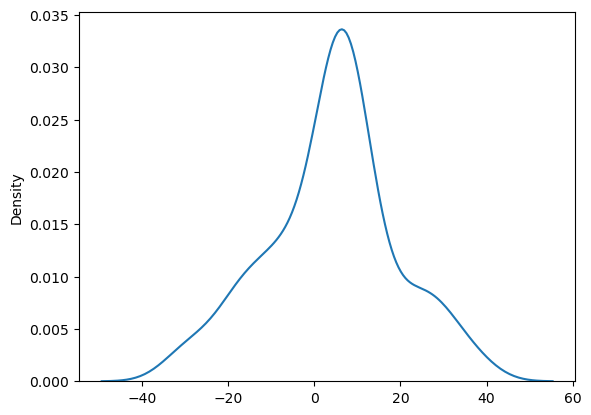

In [7]:
# shows that FEDs are normally only out of sync by 40 seconds or less
# need to inspect nans to work out what is happening there
import seaborn as sns
sns.kdeplot(offsets)

In [8]:
# saves dataframe as feather file
feddata_synced.reset_index(drop=True).to_feather("..\\processeddata\\feddata_synced.feather")  